# 8강. 영화리뷰 텍스트 감성분석하기
## 8-4. 텍스트 데이터의 특징_텍스트를 숫자로 표현하는 방법

In [1]:
# 처리해야 할 문장 리스트에 옮겨 담기
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# split() 메소드를 이용해 단어 단위로 문장을 쪼개기
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
# 딕셔너리 자료구조로 표현
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 보기. 채우는 순서는 임의로. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어주기
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
# 텍스트:인덱스 구조로 바꾸기
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])

4


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수 만들기
# 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [6]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# encode된 벡터를 decode해 원래 텍스트 데이터로 복구하기
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


## 8-5. 텍스트 데이터의 특징_Embedding 레이어의 등장

In [9]:
# Embedding 레이어를 활용하여 텍스트 데이터를 워드 벡터 텐서 형태로 다시 표현하기
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
output = embedding(raw_inputs)
print(output)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

- Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 하는데, raw_inputs의 3개 벡터의 길이는 각각 4, 4, 5로 다르기 때문에 에러가 발생한다.
- < PAD >를 추가해서 길이를 일정하게 맞추고 다시 Embedding하기>>tf.keras.preprocessing.sequence.pad_sequences함수 이용

In [10]:
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [11]:
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.02307391 -0.03128791 -0.00330249 -0.02660018]
  [-0.04700475  0.04807322  0.03738046 -0.00421745]
  [ 0.04574995 -0.0382056  -0.03498161 -0.03734356]
  [-0.01781031  0.02289781  0.01297228  0.02568728]
  [ 0.04423035  0.00701569  0.02390343  0.04349377]]

 [[-0.02307391 -0.03128791 -0.00330249 -0.02660018]
  [-0.04700475  0.04807322  0.03738046 -0.00421745]
  [ 0.04435127 -0.03624574 -0.03449403  0.02806279]
  [ 0.00638175 -0.03508365  0.02089206 -0.01674972]
  [ 0.04423035  0.00701569  0.02390343  0.04349377]]

 [[-0.02307391 -0.03128791 -0.00330249 -0.02660018]
  [ 0.04336791 -0.03324915  0.03357748  0.04002818]
  [-0.04700475  0.04807322  0.03738046 -0.00421745]
  [ 0.04574995 -0.0382056  -0.03498161 -0.03734356]
  [ 0.00649009 -0.01729052  0.02014321 -0.00821001]]], shape=(3, 5, 4), dtype=float32)


- shape=(3, 5, 4)  
3은 입력문장 개수, 5는 입력문장의 최대 길이, 4는 워드 벡터의 차원 수

In [12]:
# RNN모델을 통해 텍스트 데이터 처리
vocab_size = 10 # 어휘 사전의 크기(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM사용. LSTM state 벡터의 차원수는 8.
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 2dim이다

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


input_shape=(None, ) -> 크기가 아직 정해지지 않았으며 자동으로 처리한다는 의미  
input shape=(문장의 개수, 각 문장 당 단어(토큰)의 개수)  
output shape=(batch_size, input_length, output_dim)  
[input shape None](https://datascience.stackexchange.com/questions/54159/what-does-an-input-layer-of-shape-none-or-none-12-actually-mean)  
- (3,5) -> (3,5,4)로 만들어 주기 : (None,) -> (None,4) -> (15,4) -> (3,5,4)

## 8-7. 꼭 RNN이어야 할까?
- 1-D CNN : 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식

In [13]:
# CNN
vocab_size = 10 # 어휘 사전의 크기(10개 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) # (커널 개수, 커널크기, 활성화함수)
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
# GlobalMaxPooling1D() 레이어 하나만 사용해보기
vocal_size = 10 # 어휘 사전의 크기(10개의 단어)
word_vector_dim = 4 # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## 8-8. IMDB 영화리뷰 감성분석 (1) IMDB 데이터셋 분석

IMDb Large Movie Dataset은 50000개의 영어로 작성된 영화 리뷰 텍스트로 구성되어 있으며, 긍정은 1, 부정은 0의 라벨이 달려 있다. 50000개 중 25000개가 훈련용 데이터, 나머지 25000개가 테스트용 데이터로 사용되도록 지정되어있다.

In [15]:
imdb = tf.keras.datasets.imdb

# IMDB 데이터셋 다운로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000) 
 # 10000개의 word_to_index 딕셔너리까지 생성
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [16]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨(긍정1, 부정0)
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


- 텍스트 데이터가 아닌 이미 숫자로 encode된 텍스트 데이터였다. -> IMDb 데이터셋에는 encode에 사용한 딕셔너리까지 함께 제공된다는 사실을 알 수 있다.

In [17]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])
print(word_to_index['the'])

1654784/1641221 [==============================] - 0s 0us/step
the
1


In [18]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

- IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 보정이 필요하다. 보정 전 확인한 데이터를 보면 토큰이 다 섞여있다.

In [19]:
# 매핑 보정 작업 (word_to_index는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬)

# 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있다.(보정필요)
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있음
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 출력 
print(word_to_index['the'])  # 4 출력 
print(index_to_word[4])     # 'the' 출력

<BOS>
4
the


In [20]:
# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [21]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


## 8-9. IMDB 영화리뷰 감성분석_딥러닝 모델 설계와 훈련

### padding을 post로 했을 때 학습

In [22]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [23]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수는 16 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM사용. LSTM state 벡터의 차원수는 8.
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [24]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건은 train set
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 25s 46ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6930 - accuracy: 0.5130 - val_loss: 0.6931 - val_accuracy: 0.5008
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6926 - accuracy: 0.5135 - val_loss: 0.6930 - val_accuracy: 0.5009
Epoch 4/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6918 - accuracy: 0.5123 - val_loss: 0.6925 - val_accuracy: 0.5014
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6899 - accuracy: 0.5142 - val_loss: 0.6919 - val_accuracy: 0.5027
Epoch 6/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6847 - accuracy: 0.5187 - val_loss: 0.6895 - val_accuracy: 0.5074
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6769 - accuracy: 0.5290 - val_loss: 0.6905 - val_accuracy: 0.5083
Epoch 8/20
3

In [26]:
# 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.6979 - accuracy: 0.5073
[0.6979069709777832, 0.5072799921035767]


In [27]:
# train/validation loss, accuracy등이 매 epoch마다 history변수에 저장
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


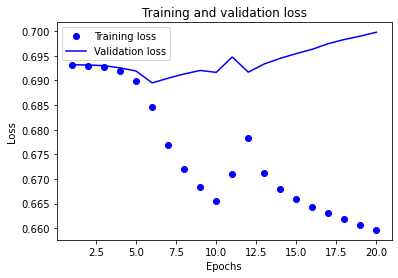

In [28]:
# 그래프로 그려보기
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- validation loss의 그래프가 train loss와 이격이 발생하면 더 이상 학습은 무의미하다. (accuracy도 마찬가지)

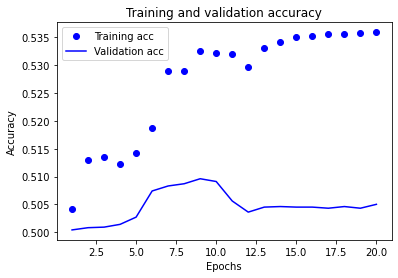

In [29]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### padding을 pre로 했을 때 학습

In [30]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [31]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수는 16 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM사용. LSTM state 벡터의 차원수는 8.
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [32]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건은 train set
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_pre = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 44ms/step - loss: 0.6930 - accuracy: 0.5090 - val_loss: 0.6930 - val_accuracy: 0.5008
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6926 - accuracy: 0.5094 - val_loss: 0.6925 - val_accuracy: 0.5053
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6914 - accuracy: 0.5081 - val_loss: 0.6918 - val_accuracy: 0.5017
Epoch 4/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6870 - accuracy: 0.5216 - val_loss: 0.6880 - val_accuracy: 0.5099
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6844 - accuracy: 0.5290 - val_loss: 0.6912 - val_accuracy: 0.5078
Epoch 6/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6825 - accuracy: 0.5317 - val_loss: 0.6898 - val_accuracy: 0.5068
Epoch 7/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6778 - accuracy: 0.5293 - val_loss: 0.6877 - val_accuracy: 0.5095
Epoch 8/20
30

In [34]:
# 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.6898 - accuracy: 0.5106
[0.6898066997528076, 0.5105599761009216]


In [35]:
# train/validation loss, accuracy등이 매 epoch마다 history변수에 저장
history_dict_pre = history_pre.history
print(history_dict_pre.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


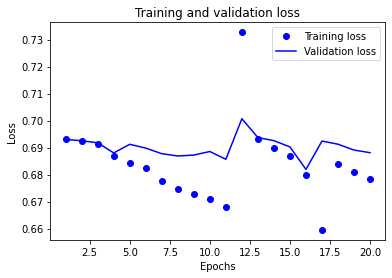

In [36]:
# 그래프로 그려보기
import matplotlib.pyplot as plt

acc = history_dict_pre['accuracy']
val_acc = history_dict_pre['val_accuracy']
loss = history_dict_pre['loss']
val_loss = history_dict_pre['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

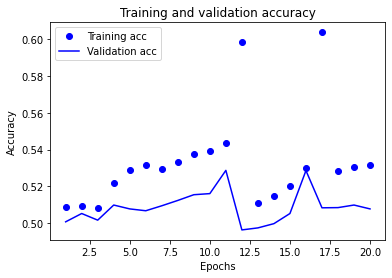

In [37]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- pre 그래프가 더 잘 학습되는 것처럼 보인다.

## 8-10. IMDB 영화리뷰 감성분석 (3) Word2Vec의 적용

In [38]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) #(vocab_size, embedding_dim)

(10000, 16)


In [44]:
# 학습된 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
 # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
# Embedding 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.03361201, -0.02208494, -0.04450186,  0.03279671,  0.00988177,
       -0.03448844, -0.0637789 , -0.02116746, -0.01606074,  0.02184756,
        0.0927799 ,  0.07301202, -0.05999483,  0.0659579 , -0.05472784,
       -0.04251133], dtype=float32)

In [46]:
# love와 유사한 단어 찾아보기
word_vectors.similar_by_word('love')

[('candy', 0.956904947757721),
 ('pompous', 0.9516978859901428),
 ('kells', 0.9488721489906311),
 ('conversation', 0.9397078156471252),
 ('searching', 0.9396218657493591),
 ('emerges', 0.9375354051589966),
 ('dense', 0.9370498061180115),
 ('savage', 0.9337807893753052),
 ('amazing', 0.9328797459602356),
 ('feeling', 0.9312423467636108)]

- 감성 분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 어렵다. 그래서 구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 가져다 활용할 것이다.
- 사전에 학습된 Word2Vec 등의 임베딩 모델을 활용하는 전이학습(Transfer Learning)을 하면 광범위한 데이터를 통해 미리 학습해 놓은 임베딩 속에 녹아 있는 의미, 문법 등의 부가적인 정보를 내가 만들려는 모델이 활용할 수 있는 피처로 활용하는 것이 훨씬 빠르고 정확하게 학습할 수 있다.

In [47]:
# Google의 Word2Vec 모델 가져오기
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 300dim의 워드 벡터로 이루어진 300만 개의 단어 -> 메모리를 위해 상위 100만 개로 limit

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [48]:
# love와 유사한 단어 찾아보기
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [49]:
# 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [50]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 300 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [51]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 16s 87ms/step - loss: 0.6883 - accuracy: 0.5438 - val_loss: 0.6743 - val_accuracy: 0.5785
Epoch 2/20
30/30 [==============================] - 2s 68ms/step - loss: 0.6382 - accuracy: 0.6483 - val_loss: 0.6092 - val_accuracy: 0.6920
Epoch 3/20
30/30 [==============================] - 2s 68ms/step - loss: 0.5195 - accuracy: 0.7721 - val_loss: 0.4530 - val_accuracy: 0.8085
Epoch 4/20
30/30 [==============================] - 2s 68ms/step - loss: 0.3713 - accuracy: 0.8467 - val_loss: 0.3682 - val_accuracy: 0.8435
Epoch 5/20
30/30 [==============================] - 2s 68ms/step - loss: 0.2667 - accuracy: 0.8981 - val_loss: 0.3273 - val_accuracy: 0.8622
Epoch 6/20
30/30 [==============================] - 2s 69ms/step - loss: 0.1919 - accuracy: 0.9376 - val_loss: 0.3147 - val_accuracy: 0.8662
Epoch 7/20
30/30 [==============================] - 2s 68ms/step - loss: 0.1379 - accuracy: 0.9627 - val_loss: 0.3353 - val_accuracy: 0.8605
Epoch 8/20
3

In [52]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.4839 - accuracy: 0.8592
[0.4838990867137909, 0.8591600060462952]


- Word2Vec을 잘 활용하면 그렇지 않은 경우보다 5% 이상의 성능 향상이 발생한다. 적절한 모델 구성, 하이퍼파라미터를 고려하여 감정 분석 모델의 성능을 최대한으로 끌어올릴 수 있다.